<a href="https://colab.research.google.com/github/anujgupta82/NLP_Bootcamp/blob/V_2_0/module2/glove/word2vec_glove_model_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction to Glove model 

##### Author - Satyam 

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.11-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.11-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.11-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [5]:
!pip install mpld3==0.3
!pip install --user "git+https://github.com/javadba/mpld3@display_fix"

     |████████████████████████████████| 798kB 6.3MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=116679 sha256=0c022dca80babc98272749889bca2f5dac3943a3b4d66846b31f92b587c9b5fc
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3
  Cloning https://github.com/javadba/mpld3 (to revision display_fix) to /tmp/pip-req-build-ek0_epp0
  Running command git clone -q https://github.com/javadba/mpld3 /tmp/pip-req-build-ek0_epp0
  Running command git checkout -b display_fix --track origin/display_fix
  Switched to a new branch 'display_fix'
  Branch 'display_fix' set up to track remote branch 'display_fix' from 'origin'.
  Running command git submodule update --init --recursive -q
  Created wheel for mpld3: filename=mpld3-0.3.1.dev1-cp36-none-any.whl size=116957 sha256=daed90ee42269d02732929f01e7ca9c6c257fa3516c66f174f670c2c0e7164c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-b4tw1w6f/wh

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from pylab import rcParams
import mpld3
import sys
import numpy as np 
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt 

np.random.seed(0)
sys.path.append("/content/drive/GoogleDrive_Utils/")

rcParams['figure.figsize'] = 8, 8
mpld3.enable_notebook()

In [0]:
#from readWikiData import *
from readWikiData import get_wikipedia_data

In [0]:
def build_co_occur_matrix(sentences, vocab_size, window_size, cc_matrix=None):
    X = np.zeros((vocab_size, vocab_size))                    
    for sentence in sentences:
        n = len(sentence)
        for i in range(n):
            wi = sentence[i] 
            
            start = max(0, i - window_size)
            end = min(n, i + window_size)
            
            if i - window_size < 0:
                points = 1.0/(1 + i)
                X[wi, 0] += points
                X[0, wi] += points
            
            if i + window_size > n:
                points = 1.0/( n - i)
                X[wi, 0] += points
                X[0, wi] += points
                
            for j in range(start, i):
                points = 1.0/(i - j)
                wj = sentence[j]
                X[wi, wj] += points
                X[wj, wi] += points
                
            for j in range(i + 1, end):
                points = 1.0/(j - i)
                wj = sentence[j]
                X[wi, wj] += points
                X[wj, wi] += points
    #np.save(X, cc_matrix)
    return X

Glove model normalize the co-occurence score of each using the following equation :- 

$$f_{i, j}(X) = \left( \frac{X_{i, j}}{X_{max}} \right)^\alpha     ,if X_{i, j} < X_{max} $$
$$= 1, otherwise $$

In [0]:
def getfX(X, xmax, alpha):
    fX = np.zeros(X.shape)
    fX[X < xmax] = (X[X<xmax]/float(xmax))**alpha
    fX[X >= xmax] = 1.0 
    return fX

The cost function in the glove model tries to learn a lower dimensional representation of the input coocurrence matrix
using the following equation :- 

$$J = \sum_{i}\sum_{j} f\left(X_{i, j}\right)\left(w_{i}^T u_{j} + b_{i} + c_{j} + mu - \log X_{i, j} \right)^2 
+ \lambda \left( {\lVert W \rVert }^2 + {\lVert u \rVert }^2 + {\lVert b \rVert }^2 + {\lVert c \rVert }^2 \right)$$

In [0]:
def normalize(X):
    return np.log(X + 1)

In [0]:
sentences, word2idx,  idx2word, original_sentence = get_wikipedia_data(n_files=20, n_vocab=2000, by_paragraph=True)

In [0]:
X = build_co_occur_matrix(sentences=sentences, vocab_size=len(word2idx), window_size=3)

In [0]:
fX = getfX(X=X, xmax=100, alpha=0.75)

In [0]:
logX = normalize(X=X)

In [0]:
V = len(word2idx)
embedding_size = 50
learning_rate = 10e-5
epochs = 10001
reg=0.01

In [0]:
W = np.random.randn(V, embedding_size)/np.sqrt(V + embedding_size)
b = np.zeros(V)
U = np.random.randn(V, embedding_size)/np.sqrt(V + embedding_size)
c = np.zeros(V)
mu = normalize(X).mean()

In [0]:
tfW = tf.Variable(W.astype(np.float32))
tfb = tf.Variable(b.reshape(V, 1).astype(np.float32))
tfU = tf.Variable(U.astype(np.float32))
tfc = tf.Variable(c.reshape(1, V).astype(np.float32))
tfLogX = tf.placeholder(tf.float32, shape=(V, V))
tffX = tf.placeholder(tf.float32, shape=(V, V))

In [0]:
delta = tf.matmul(tfW, tf.transpose(tfU)) + tfb + tfc + mu - tfLogX
cost = tf.reduce_sum(tffX * delta * delta)
for param in (tfW, tfb, tfU, tfc):
    cost += reg*tf.reduce_sum(param * param)

In [0]:
train_op = tf.train.MomentumOptimizer(learning_rate, momentum=0.9).minimize(cost)
init = tf.global_variables_initializer()
session = tf.InteractiveSession()
session.run(init)

In [21]:
costs = []
sentence_indexes = range(len(sentences))
        
for epoch in range(epochs):
    delta = W.dot(U.T) + b.reshape(V, 1) + c.reshape(1, V) + mu - logX
    cost = ( fX * delta * delta ).sum()
    costs.append(cost)
    if epoch % 1000 == 0:
        print ("epoch:", epoch, "cost:", cost)

    session.run(train_op, feed_dict={tfLogX: logX, tffX: fX})
    W, b, U, c = session.run([tfW, tfb, tfU, tfc])

epoch: 0 cost: 2370352.7816702384
epoch: 1000 cost: 62701.61641192132
epoch: 2000 cost: 61999.87142537269
epoch: 3000 cost: 61801.07799831055
epoch: 4000 cost: 61712.85501985978
epoch: 5000 cost: 61662.61299826134
epoch: 6000 cost: 61629.669889736986
epoch: 7000 cost: 61606.688859983245
epoch: 8000 cost: 61590.075329141044
epoch: 9000 cost: 61577.61531536129
epoch: 10000 cost: 61567.97160653273


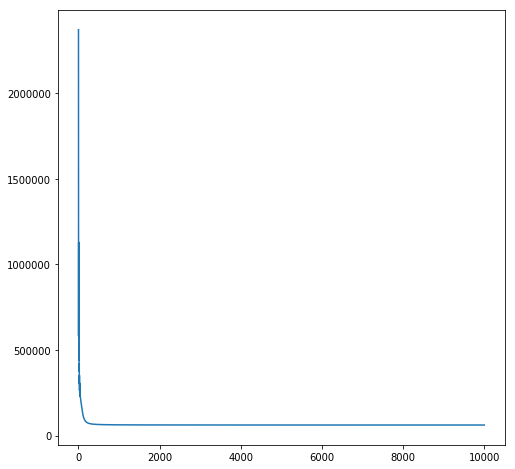

In [22]:
plt.plot(costs)
plt.show()

In [0]:
word2vec = np.mean([W, U], axis=0)

In [0]:
idx2word = {v:k for k, v in word2idx.items()}

In [0]:
from sklearn.manifold import TSNE
model = TSNE()
Z = model.fit_transform(word2vec) 

TypeError: ignored

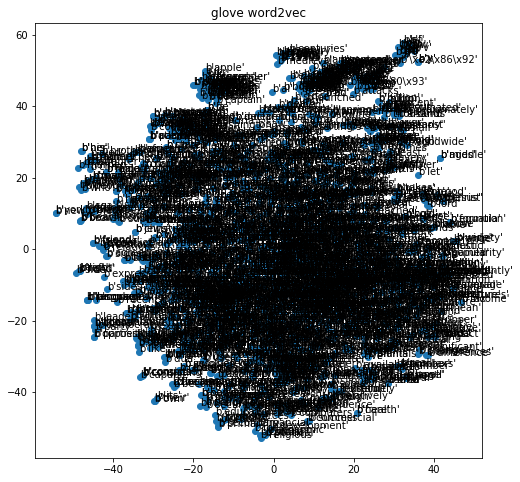

In [26]:
plt.scatter(Z[:,0], Z[:,1])
plt.title("glove word2vec")
rcParams['figure.figsize'] = 12, 12
for i in range(len(idx2word)):
    try:
        plt.annotate(s=idx2word[i].encode("utf8"), xy=(Z[i,0], Z[i,1]))
    except:
        print ("bad string:", idx2word[i])
plt.show()

In [0]:
def find_analogies(w1, w2, w3, We, word2idx):
    king = We[word2idx[w1]]
    man = We[word2idx[w2]]
    woman = We[word2idx[w3]]
    v0 = king - man + woman

    def dist1(a, b):
        return np.linalg.norm(a - b)
    def dist2(a, b):
        return 1 - a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

    for dist, name in [(dist1, 'Euclidean'), (dist2, 'cosine')]:
        min_dist = float('inf')
        best_word = ''
        for word, idx in word2idx.items():
            if word not in (w1, w2, w3):
                v1 = We[idx]
                d = dist(v0, v1)
                if d < min_dist:
                    min_dist = d
                    best_word = word
        print ("closest match by", name, "distance:", best_word)
        print (w1, "-", w2, "=", best_word, "-", w3)

In [0]:
we = word2vec
w2i = word2idx

In [29]:
find_analogies(w1='1', w2='3', w3='2',We=we, word2idx=w2i)
find_analogies(w1='england', w2='london', w3='france',We=we, word2idx=w2i)
find_analogies(w1='english', w2='french', w3='german',We=we, word2idx=w2i)
find_analogies(w1='east', w2='west', w3='north',We=we, word2idx=w2i)
find_analogies(w1='lower', w2='higher', w3='low',We=we, word2idx=w2i)
find_analogies(w1='two', w2='three', w3='four',We=we, word2idx=w2i)
find_analogies(w1='december', w2='november', w3='january',We=we, word2idx=w2i)
find_analogies(w1='december', w2='november', w3='july',We=we, word2idx=w2i)
find_analogies(w1='two', w2='three', w3='five',We=we, word2idx=w2i)
find_analogies(w1='eastern', w2='western', w3='northern',We=we, word2idx=w2i)
find_analogies(w1='king', w2='queen', w3='women',We=we, word2idx=w2i)

closest match by Euclidean distance: 4
1 - 3 = 4 - 2
closest match by cosine distance: 4
1 - 3 = 4 - 2
closest match by Euclidean distance: spain
england - london = spain - france
closest match by cosine distance: spain
england - london = spain - france
closest match by Euclidean distance: italian
english - french = italian - german
closest match by cosine distance: italian
english - french = italian - german
closest match by Euclidean distance: south
east - west = south - north
closest match by cosine distance: south
east - west = south - north
closest match by Euclidean distance: high
lower - higher = high - low
closest match by cosine distance: high
lower - higher = high - low
closest match by Euclidean distance: five
two - three = five - four
closest match by cosine distance: five
two - three = five - four
closest match by Euclidean distance: april
december - november = april - january
closest match by cosine distance: april
december - november = april - january
closest match by Eu

TypeError: ignored

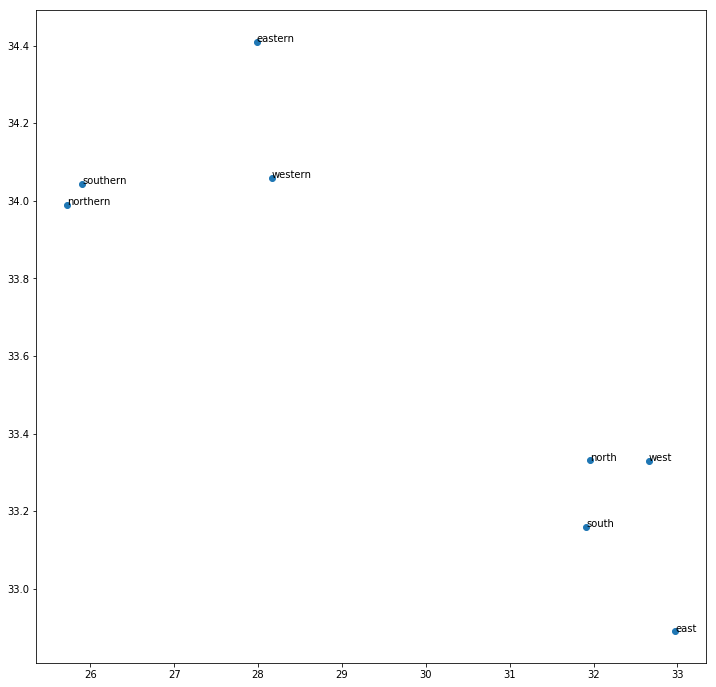

In [30]:
words = ['east', 'eastern', 'west', 'western', 'north', 'northern', 'south', 'southern']

idx = [word2idx[w] for w in words]

tsne = TSNE()
Z = tsne.fit_transform(we)
Z = Z[idx]
plt.scatter(Z[:,0], Z[:,1])
for i in range(len(words)):
    plt.annotate(s=words[i], xy=(Z[i,0], Z[i,1]))
plt.show()

TypeError: ignored

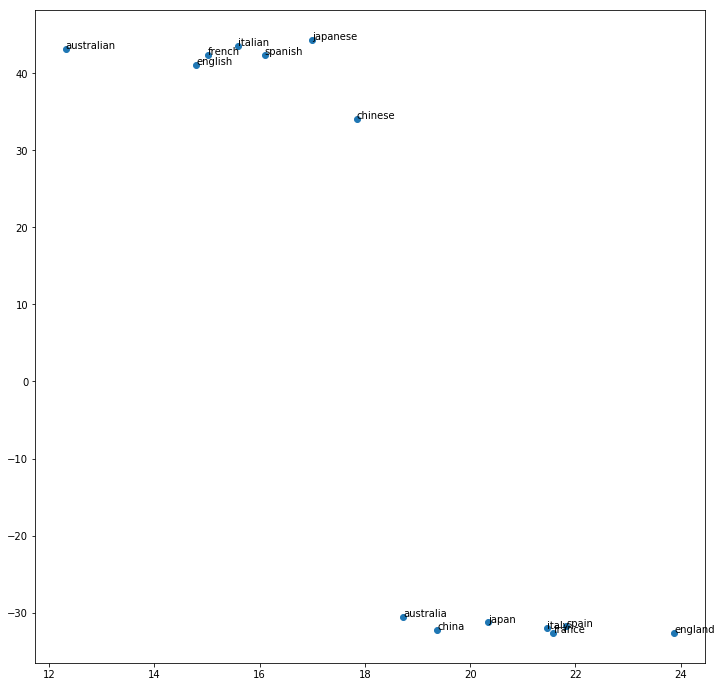

In [31]:
words = ['japan', 'japanese', 'england', 'english', 'australia', 'australian', 'china', \
         'chinese', 'italy', 'italian', 'french', 'france', 'spain', 'spanish']

idx = [word2idx[w] for w in words]

tsne = TSNE()
Z = tsne.fit_transform(we)
Z = Z[idx]

plt.scatter(Z[:,0], Z[:,1])
for i in range(len(words)):
    plt.annotate(s=words[i], xy=(Z[i,0], Z[i,1]))

plt.show()

TypeError: ignored

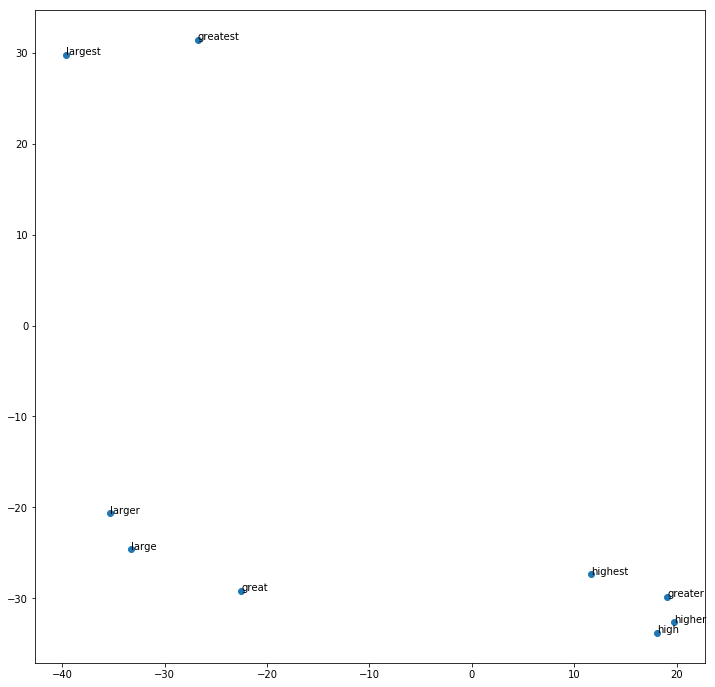

In [32]:
words = ['large', 'larger', 'largest', 
         'great', 'greater', 'greatest', 
         'high', 'higher', 'highest']

idx = [word2idx[w] for w in words]

tsne = TSNE()
Z = tsne.fit_transform(we)
Z = Z[idx]

plt.scatter(Z[:,0], Z[:,1])
for i in range(len(words)):
    plt.annotate(s=words[i], xy=(Z[i,0], Z[i,1]))

plt.show()

#### References - 

http://www.foldl.me/2014/glove-python/